In [2]:
import matplotlib.pyplot as plt
import rasterio as rio
from segmetrics import dice_coef_j, dice_coef_s, mean_iou
import os
import numpy as np

from tensorflow import keras
from tensorflow.image import resize
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy

from tensorflow.keras import Model, Sequential
from tensorflow import random_normal_initializer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

In [3]:
tiled_images_dir = "./data/tiles/images/"
tiled_masks_dir  = "./data/tiles/masks/"


tiled_img_paths = sorted([tiled_images_dir+"train/"+file for file in os.listdir(tiled_images_dir+"train/")
                   if file.endswith(".tif")])

tiled_mask_paths = sorted([tiled_masks_dir+"labels/"+file for file in os.listdir(tiled_masks_dir+"labels/")
                       if file.endswith(".tif")])

len(tiled_img_paths), len(tiled_mask_paths)

(2040, 2040)

In [4]:
def plot_img_with_mask(index, raster_img_paths = tiled_img_paths, mask_img_paths = tiled_mask_paths):
    tif_file = rio.open(raster_img_paths[index], mode = "r+").read().transpose(1,2,0)
    mask_file = rio.open(mask_img_paths[index], mode = "r+").read().transpose(1,2,0)
    plt.figure(figsize = (10,10))
    plt.imshow(tif_file)
    plt.imshow(mask_file, alpha =  0.75, cmap = "inferno")

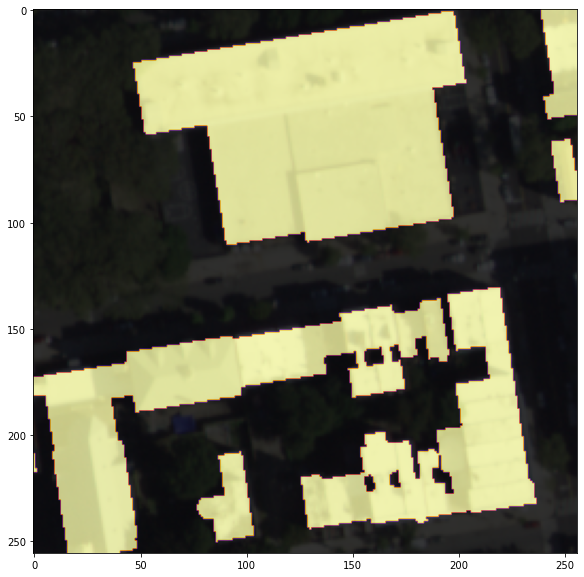

In [5]:
plot_img_with_mask(72)

In [6]:
img_dg = ImageDataGenerator(rescale=1/255., rotation_range=90.,
                            width_shift_range=0.1, height_shift_range=0.1,
                            zoom_range=0.2,
                            fill_mode="constant", cval = 0,
                            validation_split=0.15)
val_dg = ImageDataGenerator(rescale = 1/255., validation_split = 0.15)

In [7]:
seed = 2022
img_size = (256,256)
batch_sz = 16
#augmented_dir = "./data/augmented_images/"

train_image_generator = img_dg.flow_from_directory(tiled_images_dir, target_size=img_size, class_mode=None,
                                                   batch_size=batch_sz, shuffle=True, seed=seed,
                                                   subset="training")
                                                   #save_to_dir=augmented_dir+"train_images/", save_format="tif")

train_mask_generator  = img_dg.flow_from_directory(tiled_masks_dir, target_size=img_size, class_mode=None,
                                                   batch_size=batch_sz, shuffle=True, color_mode = "grayscale", seed=seed,
                                                   subset="training")
                                                   #save_to_dir=augmented_dir+"train_masks/", save_format="tif")

val_image_generator = val_dg.flow_from_directory(tiled_images_dir, target_size=img_size, class_mode=None,
                                                 batch_size=batch_sz, shuffle=True, seed=seed,
                                                 subset="validation")
                                                 #save_to_dir=augmented_dir+"val_images/", save_format="tif")

val_mask_generator  = val_dg.flow_from_directory(tiled_masks_dir, target_size=img_size, class_mode=None,
                                                 batch_size=batch_sz, shuffle=True, color_mode = "grayscale", seed=seed,
                                                 subset="validation")
                                                 #save_to_dir=augmented_dir+"val_masks/", save_format="tif")

Found 1734 images belonging to 1 classes.
Found 1734 images belonging to 1 classes.
Found 306 images belonging to 1 classes.
Found 306 images belonging to 1 classes.


In [8]:
def get_segmentation_model(shape = img_size, num_classes = 1):
    inputs = keras.Input(shape = shape + (3,))
    encoding_filters = [16,32,64,128,256]
    
    x = layers.Conv2D(encoding_filters[0], 3, strides = 2, activation = "relu", padding = "same")(inputs)
    x = layers.Conv2D(encoding_filters[0], 3, activation="relu", padding="same")(x)
    
    for n_filters in encoding_filters[1:]:
        x = layers.Conv2D(n_filters, 3, strides = 2, activation = "relu", padding = "same")(x)
        x = layers.Conv2D(n_filters, 3, activation="relu", padding="same")(x)
        
    
    for n_filters in encoding_filters[::-1]:
        x = layers.Conv2DTranspose(n_filters, 3, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(n_filters, 3, strides = 2, activation = "relu", padding = "same")(x)
        x = layers.Dropout(0.15)(x)
        
    outputs = layers.Conv2D(num_classes, 3, activation = "sigmoid", padding="same")(x)
    model = keras.Model(inputs, outputs)
    
    return model

In [9]:
def get_segmentation_model_with_skips(shape = img_size, num_classes = 1):
    ## Segmentation Model with Skip Connections a la UNet
    inputs = keras.Input(shape = shape + (3,))
    
    encoding_filters = [16,32,64,128,256]
    
    ## Encoding Section
    x = layers.Conv2D(encoding_filters[0], 3, strides = 2, activation = "relu", padding = "same")(inputs)
    x = layers.Conv2D(encoding_filters[0], 3, activation="relu", padding="same")(x)
    
    ## List of filters for encoding & decoding layers
    encoding_filters = [16,32,64,128,256]
    
    ## Stores encoding layer outputs to concatenate with corresponding decoding layer inputs
    output_dict = {encoding_filters[0]:x}
    
    for n_filters in encoding_filters[1:]:
        x = layers.Conv2D(n_filters, 3, strides = 2, activation = "relu", padding = "same")(x)
        x = layers.Conv2D(n_filters, 3, activation="relu", padding="same")(x)
        output_dict[n_filters] = x
    
    ## Decoding Section
    for n_filters in encoding_filters[::-1]:
        concat = layers.Concatenate()
        x = concat([x, output_dict[n_filters]])
        x = layers.Conv2DTranspose(n_filters, 3, activation="relu", padding="same")(x)
        x = layers.Conv2DTranspose(n_filters, 3, strides = 2, activation = "relu", padding = "same")(x)
        x = layers.Dropout(0.15)(x)
        
    outputs = layers.Conv2D(num_classes, 3, activation = "sigmoid", padding="same")(x)
    model = keras.Model(inputs, outputs)
    
    return model

In [10]:
model = get_segmentation_model_with_skips(img_size, 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   4640        conv2d_1[0][0]                   
______________________________________________________________________________________________

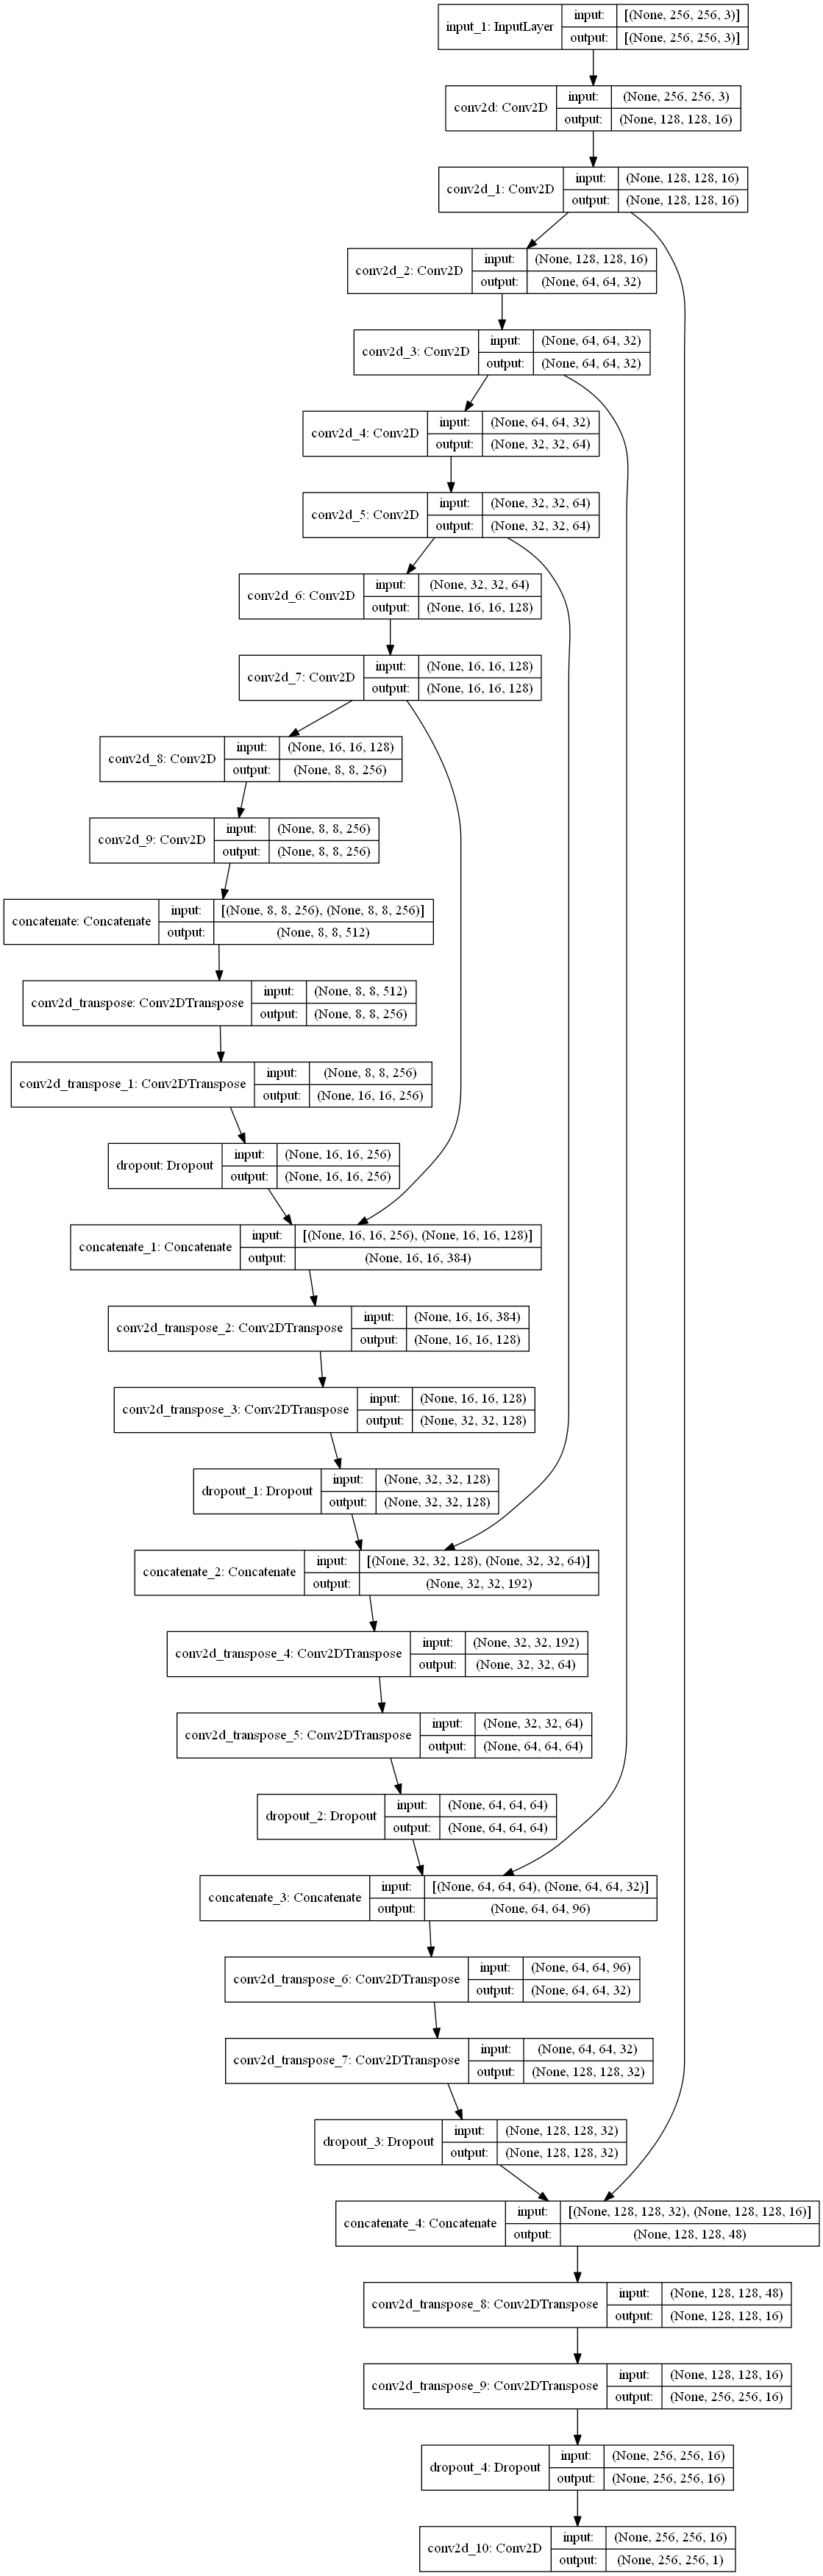

In [11]:
plot_model(model, show_shapes=True, rankdir="TB")

In [12]:
train_generator = zip(train_image_generator,train_mask_generator)
val_generator   = zip(val_image_generator, val_mask_generator)

In [302]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = [dice_coef_j, dice_coef_s, mean_iou])

callbacks = [
    keras.callbacks.EarlyStopping(monitor = "val_mean_iou", mode = "max", verbose = 1, patience = 10),
    keras.callbacks.ModelCheckpoint("segmentation_model1_checkpoint.keras", save_best_only=True,
                                    monitor = 'val_mean_iou', mode = "max")
]

train_steps = train_image_generator.samples // batch_sz
val_steps = val_image_generator.samples // batch_sz

history = model.fit(train_generator, steps_per_epoch=train_steps,
                    epochs = 30, verbose = 1,
                    callbacks=callbacks,
                    validation_data=val_generator, validation_steps=val_steps)

Epoch 1/30
108/108 [==============================] - 23s 202ms/step - loss: 0.4913 - dice_coef_j: 0.3619 - dice_coef_s: 0.2320 - mean_iou: 0.1371 - val_loss: 0.4830 - val_dice_coef_j: 0.5577 - val_dice_coef_s: 0.4053 - val_mean_iou: 0.2572
Epoch 2/30
108/108 [==============================] - 21s 200ms/step - loss: 0.3450 - dice_coef_j: 0.4706 - dice_coef_s: 0.3218 - mean_iou: 0.2027 - val_loss: 0.4188 - val_dice_coef_j: 0.6668 - val_dice_coef_s: 0.5152 - val_mean_iou: 0.3542
Epoch 3/30
108/108 [==============================] - 22s 205ms/step - loss: 0.3225 - dice_coef_j: 0.5251 - dice_coef_s: 0.3804 - mean_iou: 0.2534 - val_loss: 0.4245 - val_dice_coef_j: 0.6517 - val_dice_coef_s: 0.5084 - val_mean_iou: 0.3482
Epoch 4/30
108/108 [==============================] - 21s 200ms/step - loss: 0.3068 - dice_coef_j: 0.5441 - dice_coef_s: 0.4011 - mean_iou: 0.2727 - val_loss: 0.3759 - val_dice_coef_j: 0.7201 - val_dice_coef_s: 0.5753 - val_mean_iou: 0.4137
Epoch 5/30
108/108 [================

In [303]:
def plot_metrics(history, metric = ["loss"]):
    if type(metric) == str:
        plt.figure(figsize = (10,8))
        loss = history.history[metric]
        val_loss = history.history[f"val_{metric}"]
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, "bo", label = f"Training {metric[i]}")
        plt.plot(epochs, val_loss, "b", label = f"Validation {metric[i]}")
        plt.title(f"Training & Validation {metric[i]}")
        plt.legend()
    elif type(metric) == list:
        n_metrics = len(metric)
        fig, ax = plt.subplots(n_metrics,1, figsize = (10,n_metrics*8))
            
        for i in range(n_metrics):
            loss = history.history[metric[i]]
            val_loss = history.history[f"val_{metric[i]}"]
            epochs = range(1, len(loss) + 1)
            if n_metrics == 1:
                ax.plot(epochs, loss, "bo", label = f"Training {metric[i]}")
                ax.plot(epochs, val_loss, "b", label = f"Validation {metric[i]}")
                ax.set_title(f"Training & Validation {metric[i]}")
                ax.legend()
            else:             
                ax[i].plot(epochs, loss, "bo", label = f"Training {metric[i]}s")
                ax[i].plot(epochs, val_loss, "b", label = f"Validation {metric[i]}")
                ax[i].set_title(f"Training & Validation {metric[i]}")
                ax[i].legend()

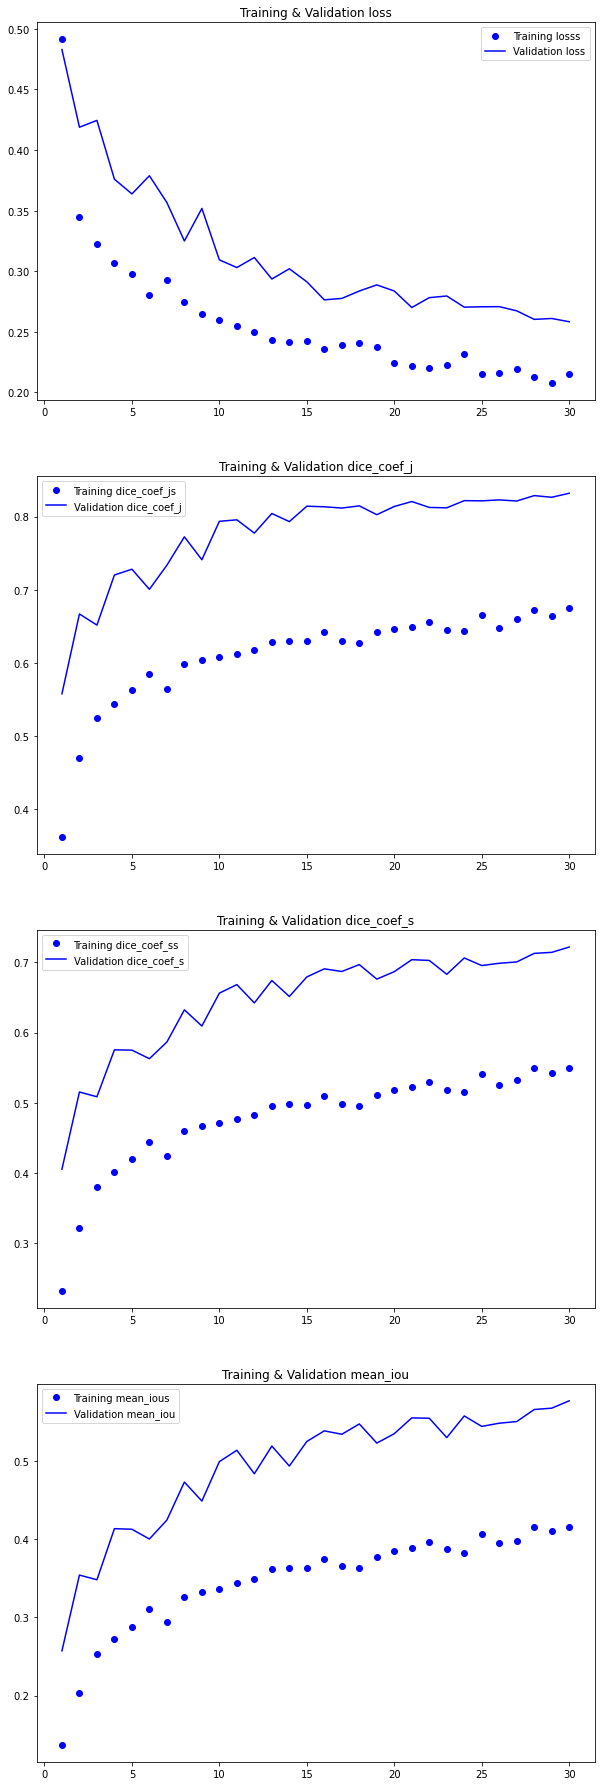

In [304]:
plot_metrics(history, metric = ["loss", "dice_coef_j", "dice_coef_s", "mean_iou"])

In [13]:
best_model = keras.models.load_model("segmentation_model1_checkpoint.keras",
                                     custom_objects={
                                         "dice_coef_j":dice_coef_j,
                                         "dice_coef_s":dice_coef_s,
                                         "mean_iou":mean_iou
                                     })

In [14]:
best_model.evaluate(val_generator, steps = val_image_generator.samples // batch_sz)

19/19 [==============================] - 6s 139ms/step - loss: 0.2361 - dice_coef_j: 0.7732 - dice_coef_s: 0.6609 - mean_iou: 0.5207


[0.2361026108264923,
 0.7732386589050293,
 0.6609228253364563,
 0.5206959247589111]

In [306]:
tiled_images_dir = "./data/tiles/images/"
tiled_masks_dir  = "./data/tiles/masks/"


tiled_img_paths = sorted([tiled_images_dir+"train/"+file for file in os.listdir(tiled_images_dir+"train/")
                   if file.endswith(".tif")])

tiled_mask_paths = sorted([tiled_masks_dir+"labels/"+file for file in os.listdir(tiled_masks_dir+"labels/")
                       if file.endswith(".tif")])

len(tiled_img_paths), len(tiled_mask_paths)

(2040, 2040)

In [307]:
def load_img(index, file_list):
    img = rio.open(file_list[index], mode = 'r+').read().transpose(1,2,0)
    img = resize(np.expand_dims(img,axis = 0),(256,256))/255
    return img

def display_image_and_prediction(index=None, models = [best_model], model_names = [""], img_list = tiled_img_paths, mask_list = tiled_mask_paths, thresholds = [0.5]):
    if len(models) != len(model_names):
        print("Not enough model names provided, setting title for unnamed models to empty string.")
        model_names.extend([""]*(len(models) - len(model_names)))
        
    test_image = load_img(index, img_list)
    test_mask  = load_img(index, mask_list)
        
    fig,ax = plt.subplots(nrows=len(models), ncols=3+len(thresholds), figsize = ((len(thresholds)+3)*3, 16))
    if len(models) > 1:
        for i,model in enumerate(models):

            mask_pred = model.predict(test_image)[0]

            ax[i][0].axis("off")
            ax[i][0].imshow(test_image[0])
            ax[i][0].set_title(f"Input Raster ({index})")

            ax[i][1].axis("off")
            ax[i][1].imshow(test_mask[0], cmap = "inferno")
            ax[i][1].set_title("True Mask")

            ax[i][2].axis("off")
            ax[i][2].imshow(mask_pred, cmap = "inferno")
            ax[i][2].set_title(f"Predicted Mask {model_names[i]}")

            for j,t in enumerate(thresholds, start = 3):
                ax[i][j].axis("off")
                ax[i][j].imshow(mask_pred > t, cmap = 'inferno')
                ax[i][j].set_title(f"Predicted Mask {model_names[i]} - Threshold:{t}")
        plt.tight_layout()
    else:
        mask_pred = models[0].predict(test_image)[0]

        ax[0].axis("off")
        ax[0].imshow(test_image[0])
        ax[0].set_title(f"Input Raster ({index})")

        ax[1].axis("off")
        ax[1].imshow(test_mask[0], cmap = "inferno")
        ax[1].set_title("True Mask")

        ax[2].axis("off")
        ax[2].imshow(mask_pred, cmap = "inferno")
        ax[2].set_title(f"Predicted Mask {model_names[0]}")

        for j,t in enumerate(thresholds, start = 3):
            ax[j].axis("off")
            ax[j].imshow(mask_pred > t, cmap = 'inferno')
            ax[j].set_title(f"Predicted Mask {model_names[0]} - Threshold:{t}")
    
    plt.tight_layout()

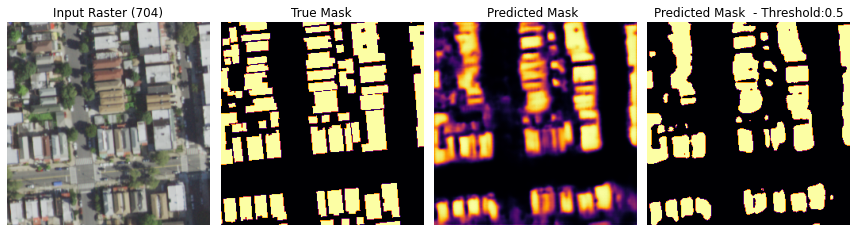

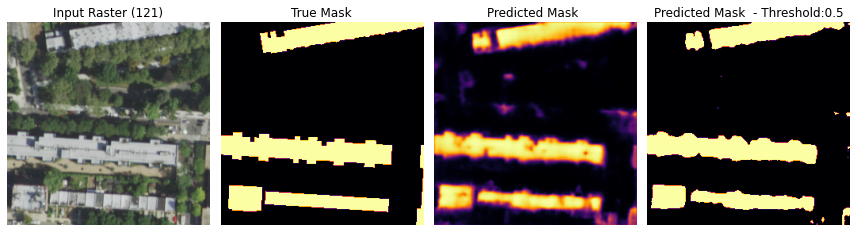

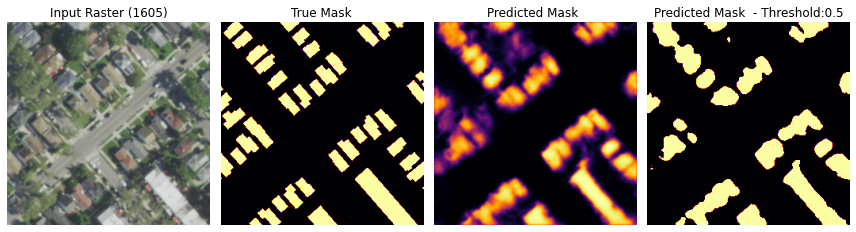

In [308]:
for _ in range(3):
    img_index = np.random.choice(len(tiled_img_paths))
    display_image_and_prediction(img_index);

## Transfer Learning with VGG16

In [317]:
from tensorflow.keras.applications import VGG16

In [318]:
vgg = VGG16(input_shape=img_size+(3,), include_top = False)

In [319]:
layer_names = [
    "block1_conv2", # 256x256
    "block2_conv2", # 128x128
    "block3_conv3", # 64x64
    "block4_conv3", # 32x32
    "block5_conv3"  # 16x16
]

vgg_outputs = [vgg.get_layer(name).output for name in layer_names]

# Create the feature extraction model
vgg_down_stack = Model(inputs=vgg.input, outputs=vgg_outputs)

vgg_down_stack.trainable = False

In [320]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [321]:
def get_segmentation_model_with_skips_pretrained(shape = img_size, num_classes = 1, model = False, model_layers = None):
    inputs = layers.Input(shape = shape + (3,)) 

    model_outputs = [model.get_layer(name).output for name in model_layers]
    model_downstack = Model(inputs = model.input, outputs = model_outputs)
    model_downstack.trainable = False

    n_filters = (len(np.binary_repr(shape[0]))-1)-len(model_outputs)

    #alternative have the range go to len(model_outputs) to have filters go to 16
    decoding_filters = [shape[0]//2**i for i in range(0,len(model_outputs)-1)]
    
    skip_outputs = model_downstack(inputs)

    x = skip_outputs[-1]
    
    ## Decoding Section
    for n_filters, layer_output in zip(decoding_filters, skip_outputs[::-1]):
        x = layers.Conv2DTranspose(n_filters, 3, activation="relu", padding="same")(x)
        concat = layers.Concatenate()
        x = concat([x, layer_output])
        x = layers.Conv2DTranspose(n_filters, 3, strides = 2, activation = "relu", padding = "same")(x)
        # concat = layers.Concatenate()
        # x = concat([x, layer_output])
        x = layers.Dropout(0.15)(x)
        
    outputs = layers.Conv2D(num_classes, 3, activation = "sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    
    return model

In [322]:
vgg_model = get_segmentation_model_with_skips_pretrained(img_size,model = vgg, model_layers=layer_names)

In [323]:
vgg_model.compile(optimizer = "adam", loss = "binary_crossentropy",
             metrics = [dice_coef_j, dice_coef_s, mean_iou])


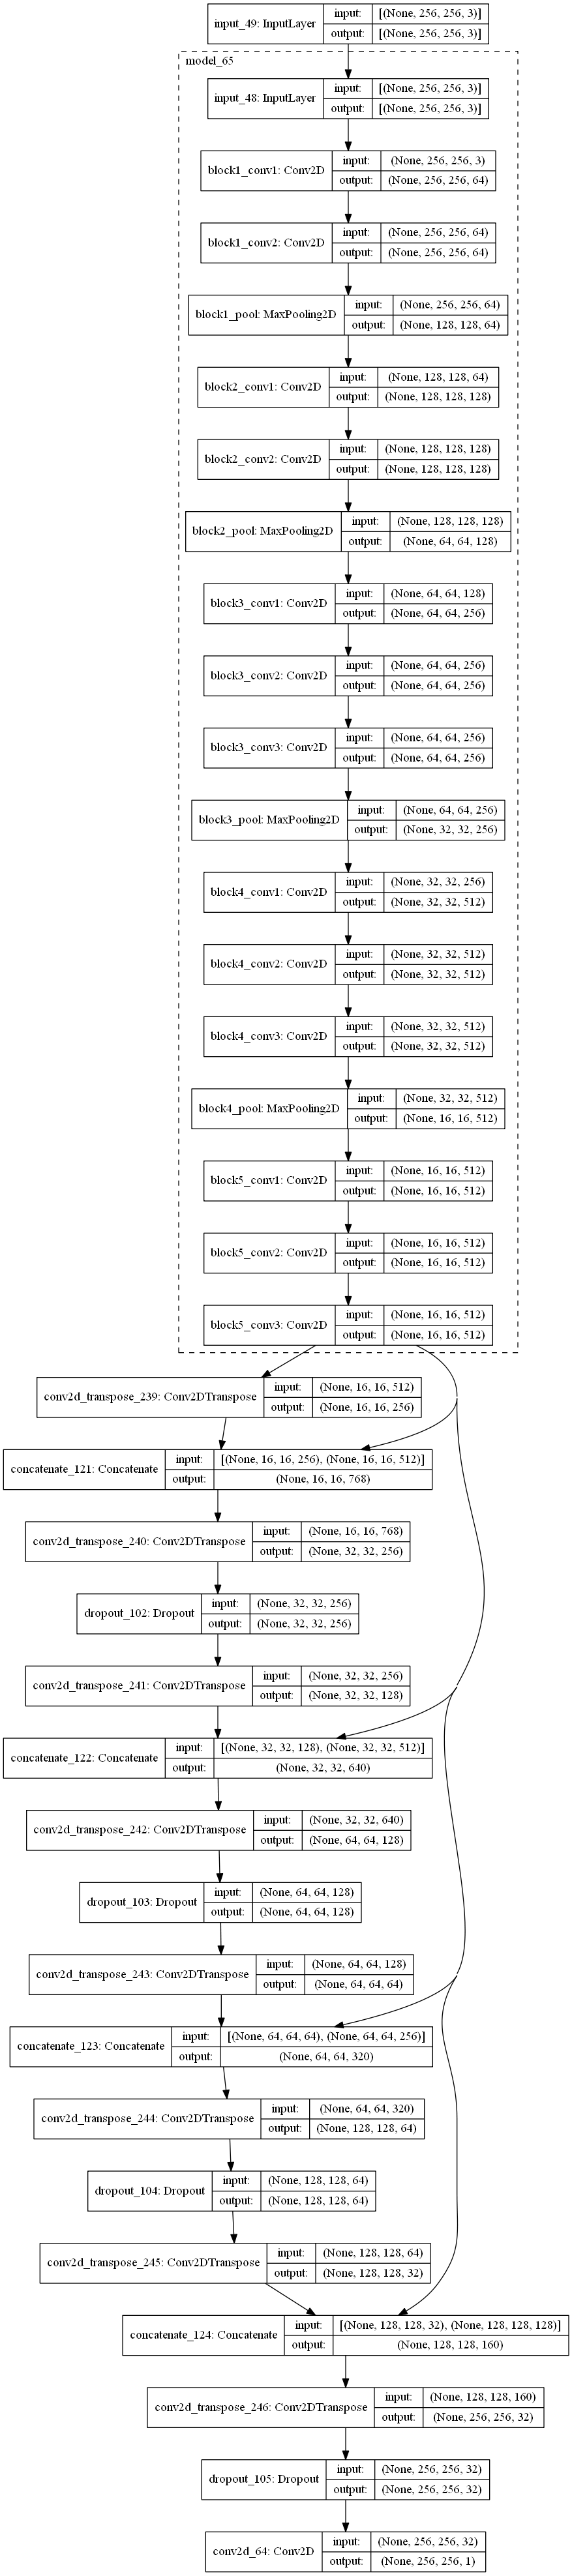

In [324]:
plot_model(vgg_model, show_shapes=True, expand_nested=True)

In [325]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor = "val_mean_iou", mode = "max", verbose = 1, patience = 10),
    keras.callbacks.ModelCheckpoint("vgg_model_checkpoint.keras", save_best_only=True,
                                    monitor = 'val_mean_iou', mode = "max")
]

history_vgg = vgg_model.fit(train_generator, epochs = 30, steps_per_epoch=train_steps, verbose = 1,
                    callbacks=callbacks, validation_data=val_generator, validation_steps=val_steps)

Epoch 1/30
108/108 [==============================] - 24s 210ms/step - loss: 0.3778 - dice_coef_j: 0.4829 - dice_coef_s: 0.3546 - mean_iou: 0.2345 - val_loss: 0.3989 - val_dice_coef_j: 0.6903 - val_dice_coef_s: 0.5589 - val_mean_iou: 0.3980
Epoch 2/30
108/108 [==============================] - 23s 209ms/step - loss: 0.2791 - dice_coef_j: 0.6012 - dice_coef_s: 0.4620 - mean_iou: 0.3256 - val_loss: 0.3384 - val_dice_coef_j: 0.7618 - val_dice_coef_s: 0.6225 - val_mean_iou: 0.4628
Epoch 3/30
108/108 [==============================] - 23s 210ms/step - loss: 0.2563 - dice_coef_j: 0.6060 - dice_coef_s: 0.4705 - mean_iou: 0.3357 - val_loss: 0.3152 - val_dice_coef_j: 0.7870 - val_dice_coef_s: 0.6535 - val_mean_iou: 0.4981
Epoch 4/30
108/108 [==============================] - 23s 211ms/step - loss: 0.2495 - dice_coef_j: 0.6370 - dice_coef_s: 0.5032 - mean_iou: 0.3663 - val_loss: 0.3043 - val_dice_coef_j: 0.8024 - val_dice_coef_s: 0.6754 - val_mean_iou: 0.5232
Epoch 5/30
108/108 [================

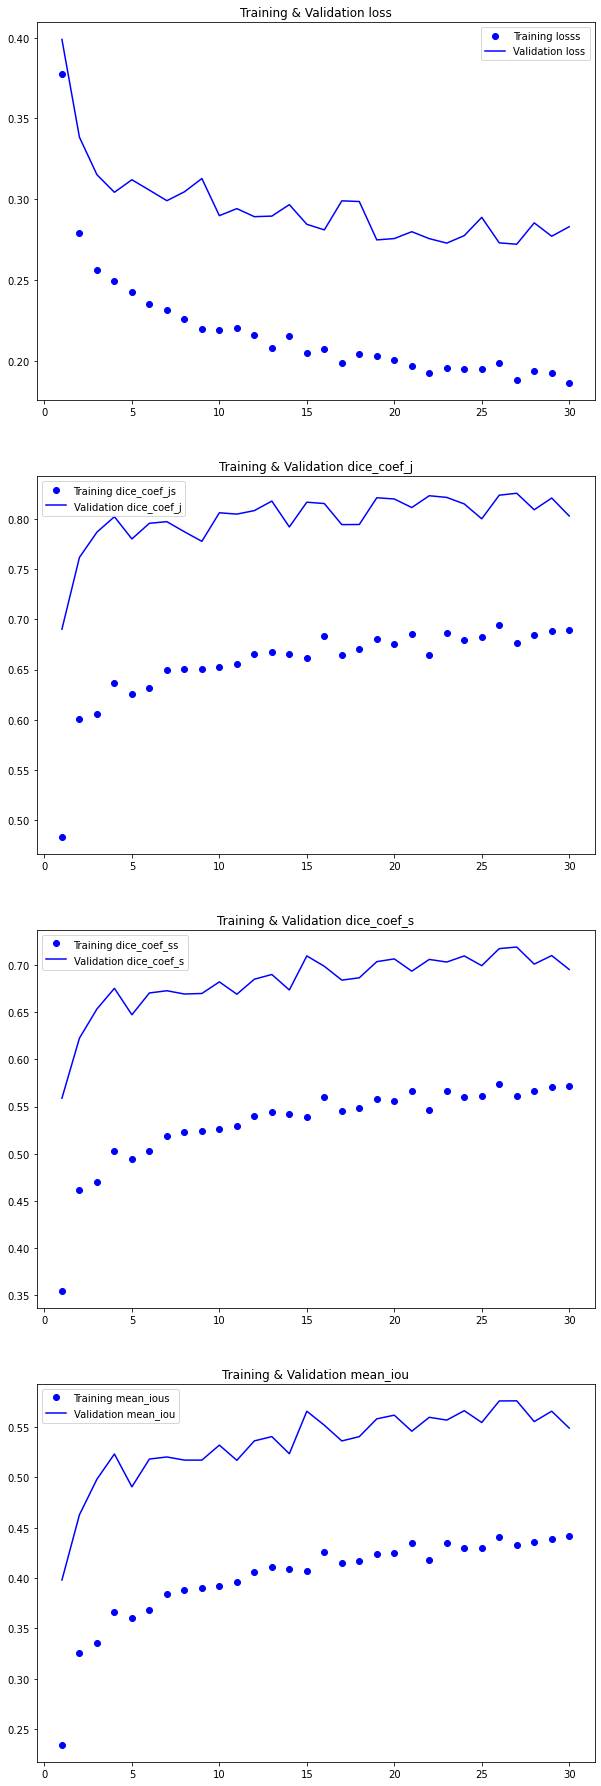

In [326]:
plot_metrics(history_vgg, metric = ["loss", "dice_coef_j", "dice_coef_s", "mean_iou"])

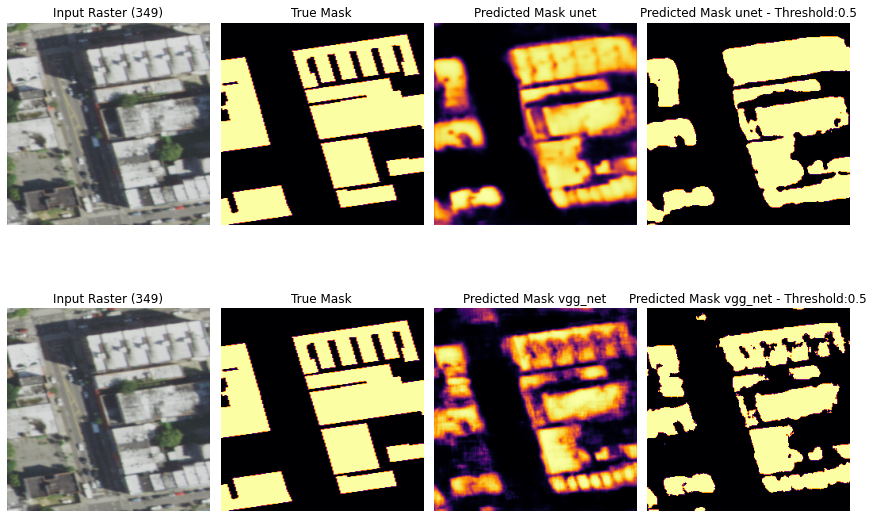

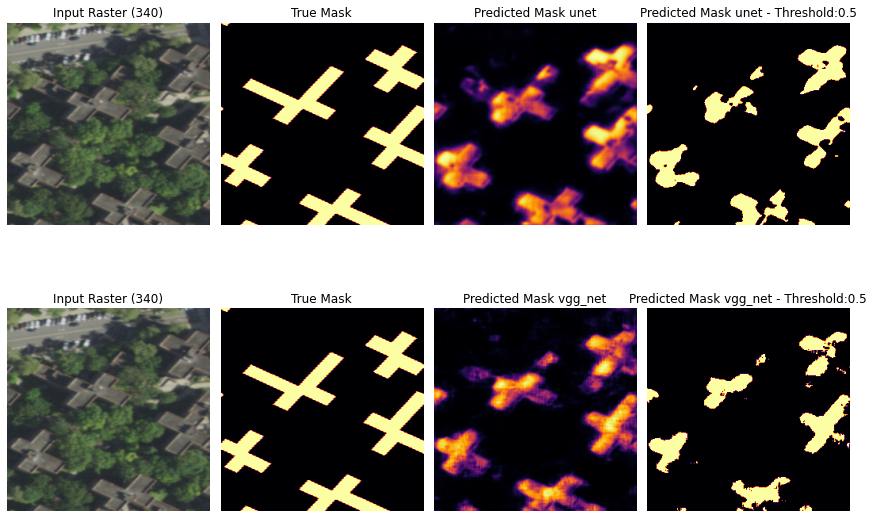

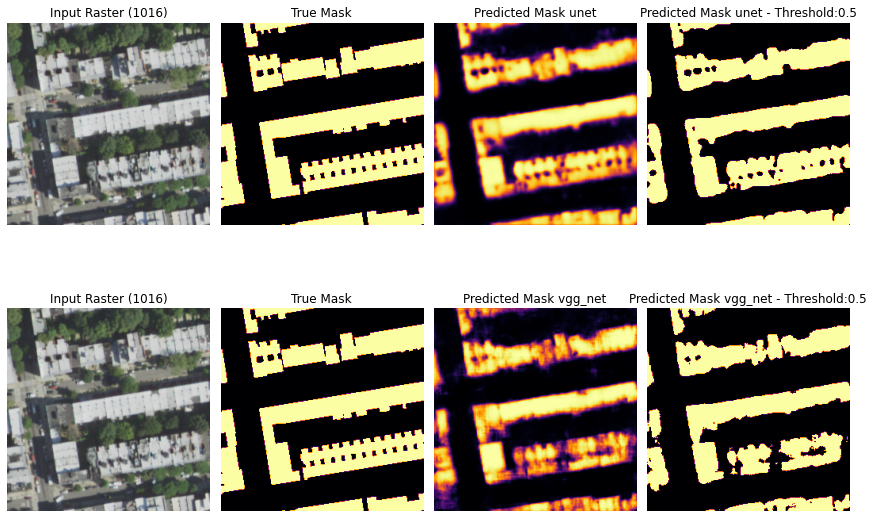

In [332]:
for _ in range(3):
    img_index = np.random.choice(len(tiled_img_paths))
    display_image_and_prediction(img_index, thresholds=[0.5],models = [best_model, vgg_model], model_names = ["unet","vgg_net"]);
    plt.tight_layout()

In [349]:
vgg_model.get_layer(index = 1).trainable = True

In [351]:
vgg_model.compile(optimizer = Adam(1e-5), loss = "binary_crossentropy",
             metrics = [dice_coef_j, dice_coef_s, mean_iou])

In [352]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor = "val_mean_iou", mode = "max", verbose = 1, patience = 10),
    keras.callbacks.ModelCheckpoint("vgg_model_checkpoint.keras", save_best_only=True,
                                    monitor = 'val_mean_iou', mode = "max")
]

history_vgg = vgg_model.fit(train_generator, epochs = 10, steps_per_epoch=train_steps, verbose = 1,
                    callbacks=callbacks, validation_data=val_generator, validation_steps=val_steps)

Epoch 1/10
108/108 [==============================] - 46s 369ms/step - loss: 0.1871 - dice_coef_j: 0.6955 - dice_coef_s: 0.5793 - mean_iou: 0.4496 - val_loss: 0.2636 - val_dice_coef_j: 0.8354 - val_dice_coef_s: 0.7278 - val_mean_iou: 0.5868
Epoch 2/10
108/108 [==============================] - 38s 354ms/step - loss: 0.1764 - dice_coef_j: 0.6880 - dice_coef_s: 0.5753 - mean_iou: 0.4489 - val_loss: 0.2635 - val_dice_coef_j: 0.8305 - val_dice_coef_s: 0.7244 - val_mean_iou: 0.5830
Epoch 3/10
108/108 [==============================] - 38s 354ms/step - loss: 0.1775 - dice_coef_j: 0.6989 - dice_coef_s: 0.5864 - mean_iou: 0.4591 - val_loss: 0.2643 - val_dice_coef_j: 0.8279 - val_dice_coef_s: 0.7243 - val_mean_iou: 0.5831
Epoch 4/10
108/108 [==============================] - 38s 353ms/step - loss: 0.1739 - dice_coef_j: 0.7119 - dice_coef_s: 0.5995 - mean_iou: 0.4713 - val_loss: 0.2631 - val_dice_coef_j: 0.8309 - val_dice_coef_s: 0.7279 - val_mean_iou: 0.5878
Epoch 5/10
108/108 [================

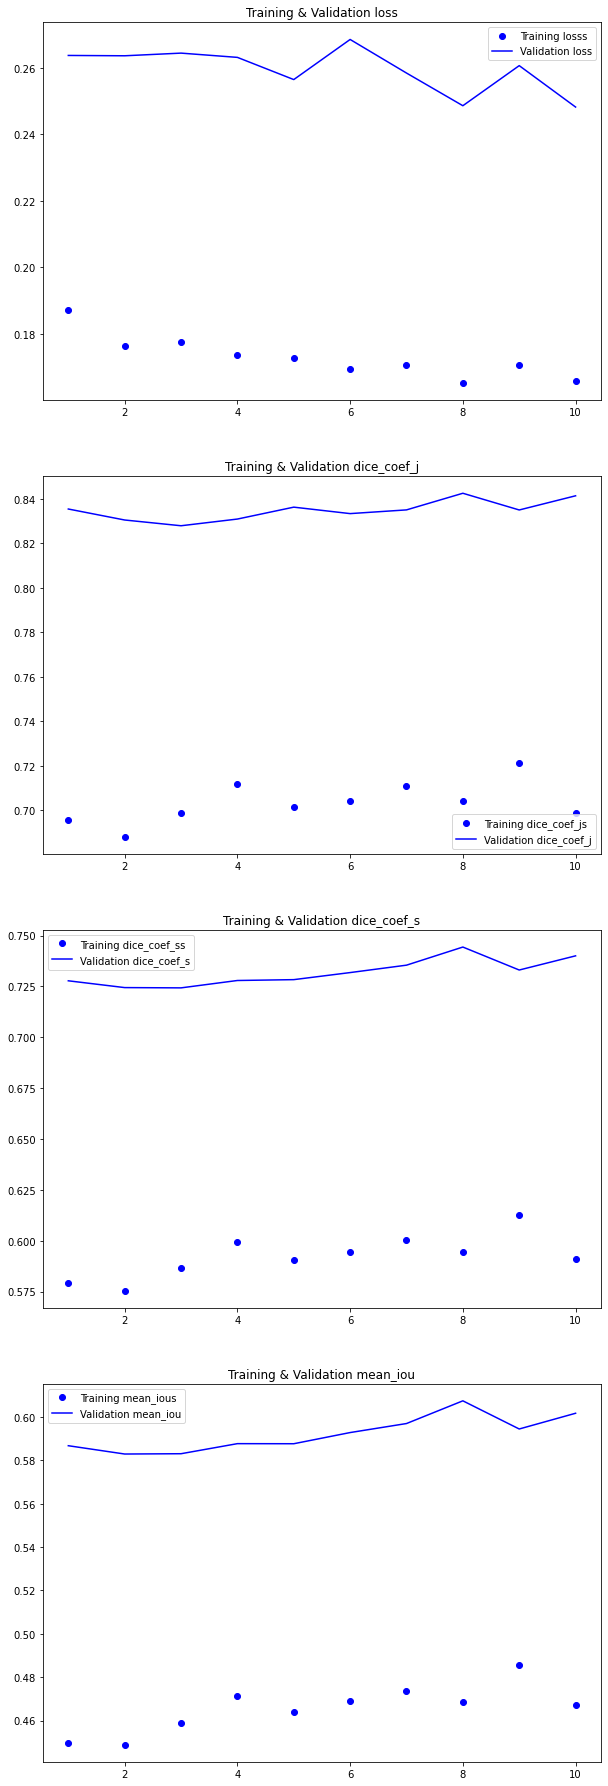

In [353]:
plot_metrics(history_vgg, metric = ["loss", "dice_coef_j", "dice_coef_s", "mean_iou"])

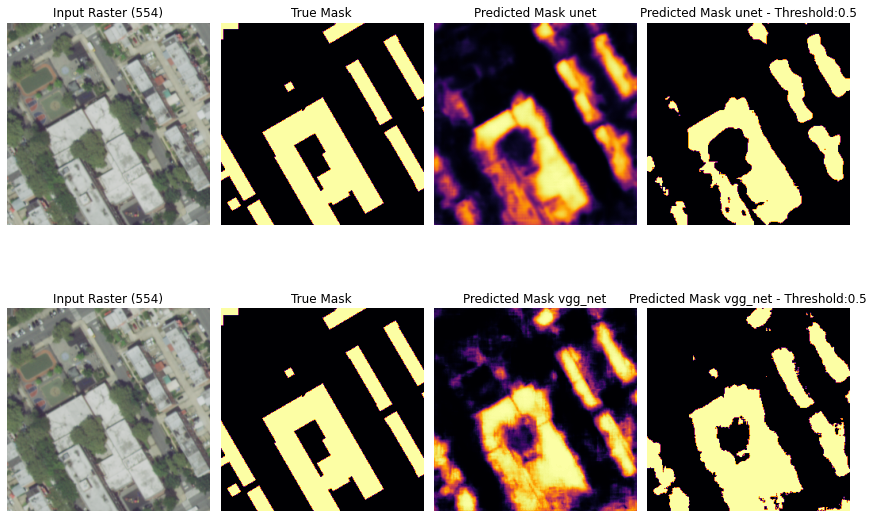

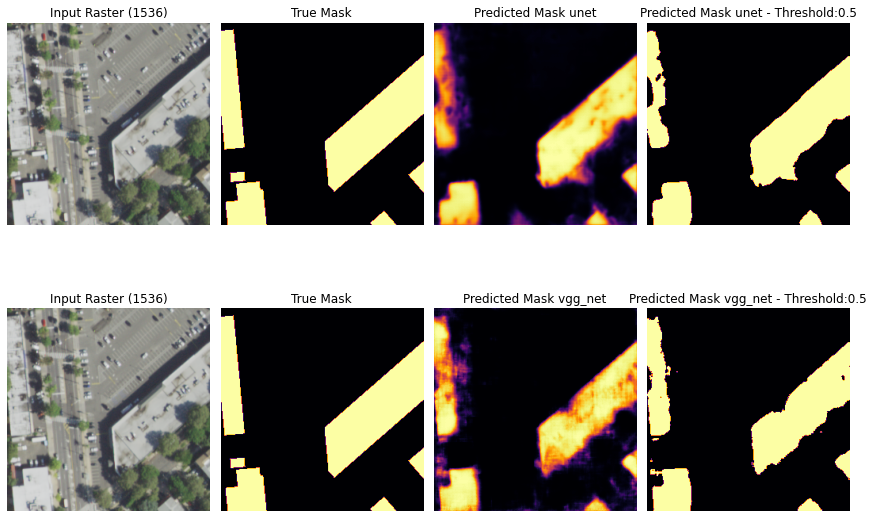

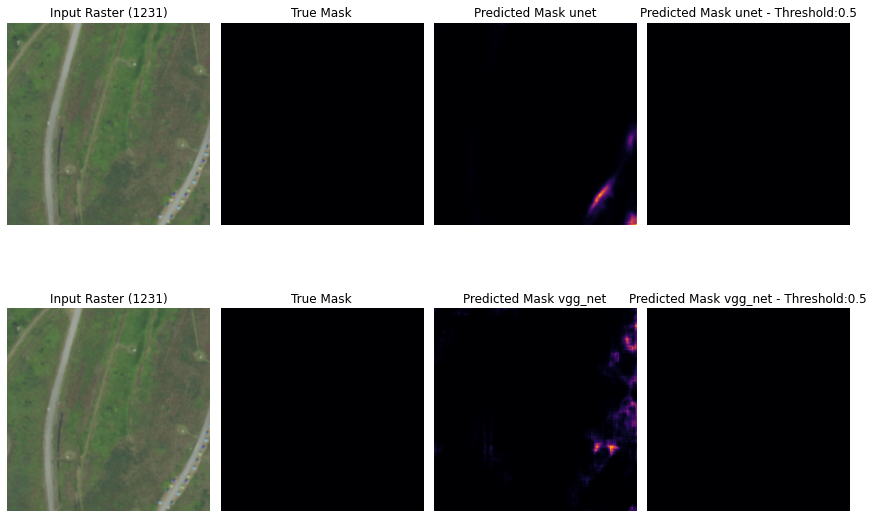

In [358]:
for _ in range(3):
    img_index = np.random.choice(len(tiled_img_paths))
    display_image_and_prediction(img_index, thresholds=[0.5],models = [best_model, vgg_model], model_names = ["unet","vgg_net"]);
    plt.tight_layout()